# Flower Feature Localization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras 
import random
from random import shuffle 
import collections
import io
import math

In [2]:
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Input, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## Data Preparation

In [3]:
FLOWERS_DIR ='dataset/Annotated-FlowerData-30'
# FLOWERS_DIR ='/content/drive/Shareddrives/Visual Information Processing/FlowerData-30'

In [14]:
H, W = 224, 224
BATCH_SIZE = 64
EPOCHS = 100

TRAIN_FRACTION = 80
RANDOM_SEED = 2018

In [132]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    FLOWERS_DIR,
    target_size=(H, W),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=RANDOM_SEED
)

Found 1982 images belonging to 30 classes.
Found 491 images belonging to 30 classes.


In [133]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 30))

In [134]:
print(train_generator.class_indices)

{'Artichoke': 0, 'Azalea': 1, 'Bearded Iris': 2, 'Bird of Paradise': 3, 'Bluebell': 4, 'Bromelia': 5, 'Buttecup': 6, 'Camellia': 7, 'Canna Lily': 8, 'Colts_Foot': 9, 'Columbine': 10, 'Cowslip': 11, 'Crocus': 12, 'Daffodil': 13, 'Daisy': 14, 'Dandelion': 15, 'Fritillary': 16, 'LilyValley': 17, 'Mexican Petunia': 18, 'Pansy': 19, 'Peruvian Lily': 20, 'Poinsettia': 21, 'Purple Coneflower': 22, 'Snapdragon': 23, 'Snowdrop': 24, 'Sunflower': 25, 'Sweet William': 26, 'Tigerlily': 27, 'Tulip': 28, 'Windflower': 29}


In [135]:
# saving labels to txt file
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)
    
print('done!')

done!


In [136]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

## MobileNetV2

MobileNet is a type of convolutional neural network designed to be lighter in terms of architecture. MobileNetV2 is only 53 layers deep. 

We implemented transfer learning by loading a pretrained MobileNetV2 (weights learned from the public ImageNet database). Several dense layer was added to the end of the model to make it classify our 30 flower classes.

In [137]:
base_model = MobileNetV2(
    input_shape=(H, W, 3), 
    weights='imagenet',
    include_top=False, 
    pooling='avg',
)

# base_model.summary()

In [138]:
base_model.trainable = False

output_class = 30

model = Sequential([
    base_model,
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(30, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_30 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_31 (Dense)             (None, 30)                15390     
Total params: 5,159,518
Trainable params: 2,901,534
Non-trainable params: 2,257,984
_________________________________________________________________


In [139]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [140]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('MobileNetV2_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

Fit model

In [143]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = train_generator.n / BATCH_SIZE, 
    validation_data = validation_generator,
    validation_steps = validation_generator.n / BATCH_SIZE,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
30/30 [==============================] - 94s 3s/step - loss: 0.0507 - accuracy: 0.9874 - val_loss: 0.3791 - val_accuracy: 0.8941

Epoch 00001: val_loss did not improve from 0.33819
Epoch 2/100
30/30 [==============================] - 100s 3s/step - loss: 0.0639 - accuracy: 0.9808 - val_loss: 0.4033 - val_accuracy: 0.8921

Epoch 00002: val_loss did not improve from 0.33819
Epoch 3/100
30/30 [==============================] - 96s 3s/step - loss: 0.0457 - accuracy: 0.9874 - val_loss: 0.3812 - val_accuracy: 0.8982

Epoch 00003: val_loss did not improve from 0.33819
Epoch 4/100
30/30 [==============================] - 97s 3s/step - loss: 0.0446 - accuracy: 0.9879 - val_loss: 0.3755 - val_accuracy: 0.8941

Epoch 00004: val_loss did not improve from 0.33819
Epoch 5/100
30/30 [==============================] - 85s 3s/step - loss: 0.0347 - accuracy: 0.9904 - val_loss: 0.3873 - val_accuracy: 0.8982

Epoch 00005: val_loss did not improve from 0.33819
Epoch 6/100
30/30 [===============

Final epoch before early stopping

```
Epoch 16/100
30/30 [==============================] - 95s 3s/step - loss: 0.0324 - accuracy: 0.9889 - val_loss: 0.3773 - val_accuracy: 0.9022

Epoch 00016: val_loss did not improve from 0.33819
Epoch 00016: early stopping
```

## Evaluating the Model

In [146]:
def plot_accuracy_loss(history):
    
    ### Plot the accuracy and the loss during the training of the nn.
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', 
             label = "Training Accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', 
             label = "Validation Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', 
             label = "Training Loss")
    plt.plot(history.history['val_loss'], 'ro--', 
             label = "Validation Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

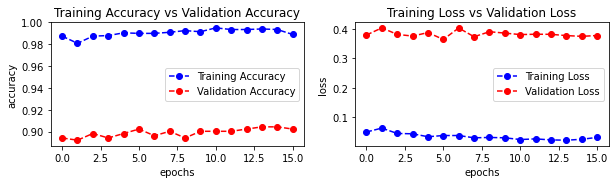

In [147]:
plot_accuracy_loss(history)

In [85]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(H, W))
    img_tensor = image.img_to_array(img) # (height, width, channels)
            
    # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)dat
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    
    img_tensor /= 255. # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

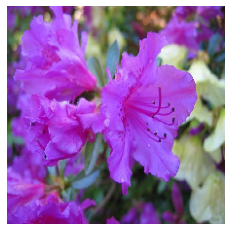

array([[9.3505204e-09, 9.9997628e-01, 6.4941013e-08, 9.2239766e-12,
        3.2494285e-08, 2.9775762e-07, 3.8282105e-10, 3.4226602e-08,
        1.0791429e-06, 6.2110622e-10, 3.5838758e-07, 7.1318507e-10,
        2.4370189e-10, 2.4117861e-09, 1.9571851e-09, 1.9607319e-06,
        7.9127926e-11, 9.2666252e-10, 2.7878798e-07, 2.3565608e-08,
        6.3072125e-06, 7.0937404e-07, 7.6837531e-10, 4.4955879e-08,
        5.0036481e-12, 3.8944025e-11, 1.2252916e-05, 8.7967479e-08,
        4.7307606e-11, 2.7773868e-07]], dtype=float32)

In [150]:
img_path = 'dataset/Test/Azalea.jpg'
new_image = load_image(img_path, show=True)

pred = model.predict(new_image)
pred

In [161]:
pred_index = [np.argmax(i) for i in pred][0]
print('Index:', pred_index)
print('Predicted Flower:', label[pred_index])
print('Prediction Probability:', pred[0][pred_index])

Index: 1
Predicted Flower: Azalea
Prediction Probability: 0.9999763


## ResNet50 and InceptionV3

Apart from MobileNetV2, we also trained 2 other types of convolutional neural networks, which are ResNet50 and InceptionV3. The training process for both networks are available in two other separate Jupyter notebooks.

ResNet: `Flower Localization - ResNet50`  
InceptionV3: `Flower Localization - InceptionV3`

## Grad-CAM

### Loading Pre-Trained Models

We have a total of 3 CNN models - MobileNetV2, ResNet50 and InceptionV3

In [162]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [163]:
mobilenet = tf.keras.models.load_model(
    'model/MobileNetV2.h5', 
    custom_objects={
        "precision_m": precision, 
        "recall_m": recall
    }
)

### Interpreting the Results

In [165]:
def decode_prediction(pred):
    # This function thresholds a probability to produce a prediction
    pred = tf.where(pred < 0.5, 0, 1)
    return pred.numpy()